# Time Series Prediction with LSTM Using PyTorch



## Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Data Plot

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/chatelet_for_prediction.csv")
df.head(3)

,Unnamed: 0,DATE,NO,NO2,PM10,CO2,TEMP,HUMI,year,month,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,2022-09-29,5.0,7.0,20.0,444.0,18.8,47.6,22,9,...,0,0,0,0,0,0,0,0,0,0
1,1,2022-09-29,3.0,23.0,11.0,450.0,17.8,50.0,22,9,...,0,0,0,0,0,0,0,0,0,0
2,2,2022-09-28,6.0,32.0,36.0,491.0,18.0,49.3,22,9,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
training_set=df['HUMI'].values.reshape(-1, 1)
training_set

array([[47.6],
       [50. ],
       [49.3],
       ...,
       [47. ],
       [47.3],
       [46.2]])

In [ ]:
time=df['DATE'].values.reshape(-1, 1)

## Dataloading

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
test_time = time[train_size:len(time)]

## Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [ ]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.35530
Epoch: 100, loss: 0.01140
Epoch: 200, loss: 0.00895
Epoch: 300, loss: 0.00501
Epoch: 400, loss: 0.00128
Epoch: 500, loss: 0.00079
Epoch: 600, loss: 0.00071
Epoch: 700, loss: 0.00065
Epoch: 800, loss: 0.00060
Epoch: 900, loss: 0.00057


## Testing for Shampoo Sales Dataset

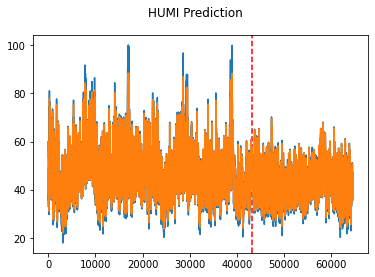

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('HUMI Prediction')
plt.show()

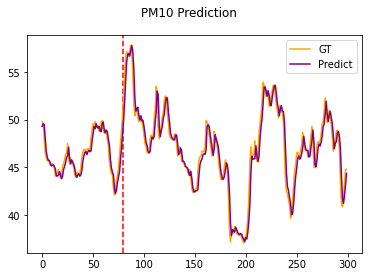

In [ ]:
plt.axvline(x=train_size-43200, c='r', linestyle='--')
plt.plot(dataY_plot[43200:43500],color='orange',label='GT')
plt.plot(data_predict[43200:43500],color='purple',label='Predict')
plt.legend()
plt.suptitle('HUMI Prediction')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_test = testY.data.numpy()

data_predict_test = sc.inverse_transform(data_predict)
dataY_test = sc.inverse_transform(dataY_test)

In [ ]:
print(f"The MAE for test data is : {mean_absolute_error(data_predict_test, dataY_test)}")
print(f"The MAPE for test data is : {mean_absolute_percentage_error(data_predict_test, dataY_test)}")

The MAE for test data is : 1.1348683834075928
The MAPE for test data is : 0.027675196528434753
